In [1]:
%matplotlib widget
import math
import numpy as np
from scipy.linalg import svd, block_diag
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cycler
from matplotlib.markers import MarkerStyle
import pandas as pd
import seaborn as sns
import torch
import itertools
from flatten_dict import flatten, unflatten
import re
import importlib

mpl.rc_file_defaults()
plt.rcParams['svg.fonttype'] = 'path'

import dd_analysis as dda
import familytree
english_tree = familytree.get_hinton_tree()

try:
    importlib.reload(util)
except NameError:
    import util
    
try:
    importlib.reload(net_analysis)
except NameError:
    import net_analysis
    
try:
    importlib.reload(pa)
except NameError:
    import problem_analysis as pa

report_titles = {
    'loss': 'Loss',
    'accuracy': 'Training sign accuracy',
    'weighted_acc': 'Training accuracy (weighted)',
    'weighted_acc_loose': 'Accuracy',
    'weighted_acc_loose_indomain': 'Training sign accuracy on same tree',
    'frac_perfect': 'Fraction perfect on training items',
    'test_accuracy': 'Test sign accuracy',
    'test_weighted_acc': 'Test sign accuracy (weighted)',
    'test_weighted_acc_indomain': 'Test sign accuracy on same tree',
    'test_frac_perfect': 'Fraction perfect on held-out items',
    'new_tree_etg': 'Epochs to learn new tree'
}

In [4]:
# Load data for analysis

try:
    curr_load_settings = load_settings
except NameError:
    curr_load_settings = {}
    
load_settings = {
    'dist_metric': 'euclidean',
    # 'corr_type': 'pearson',
    'corr_type': 'covar_centered',
    'include_rdms': True,
    'compute_full_rdms': False,
    'include_individual_corr_mats': False,
    'include_individual_rdms': False,
    'subsample_snaps': 1
}

# cache already-loaded data
curr_res_paths = {}
if load_settings == curr_load_settings:
    try:
        curr_res_paths = res_paths
    except NameError:
        res_data = {}
else:
    res_data = {}
    
tree_holdout_shared_runs = {
    'english -> english': 'data/familytree/tree_ho/shared_english_to_english_leaky_res_2021-11-29_18-51-50.npz',
    'french -> english': 'data/familytree/tree_ho/shared_french_to_english_leaky_res_2021-11-30_00-10-47.npz',
    'english -> french': 'data/familytree/tree_ho/shared_english_to_french_leaky_res_2021-11-29_21-18-03.npz',
    'french -> french': 'data/familytree/tree_ho/shared_french_to_french_leaky_res_2021-11-30_02-18-13.npz'
}

tree_holdout_separate_runs = {
    'english -> english': 'data/familytree/tree_ho/separate_english_to_english_leaky_res_2021-11-30_06-59-09.npz',
    'french -> english': 'data/familytree/tree_ho/separate_french_to_english_leaky_res_2021-11-30_15-26-12.npz',
    'english -> french': 'data/familytree/tree_ho/separate_english_to_french_leaky_res_2021-11-30_11-04-33.npz',
    'french -> french': 'data/familytree/tree_ho/separate_french_to_french_leaky_res_2021-11-30_18-24-20.npz'
}

# The commented-out ones are now under "old_or_suboptimal_lrs"
# train2_holdout1_separate_runs = {
#     'english -> english': 'data/final_runs/famnet_separate_english_to_english_res_2022-01-09_02-02-54.npz',
#     'french -> english': 'data/final_runs/famnet_separate_french_to_english_res_2022-01-12_04-53-42.npz',
#     'english -> french': 'data/final_runs/famnet_separate_english_to_french_res_2022-01-10_15-10-04.npz',
#     'french -> french': 'data/final_runs/famnet_separate_french_to_french_res_2022-01-13_13-53-46.npz'
# }

# train2_holdout1_separate_noctloss_runs = {
#     'english -> english': 'data/final_runs/famnet_separate_noctloss_english_to_english_res_2022-01-09_09-08-20.npz',
#     'french -> english': 'data/final_runs/famnet_separate_noctloss_french_to_english_res_2022-01-12_14-01-01.npz',
#     'english -> french': 'data/final_runs/famnet_separate_noctloss_english_to_french_res_2022-01-10_21-26-49.npz',
#     'french -> french': 'data/final_runs/famnet_separate_noctloss_french_to_french_res_2022-01-13_20-32-23.npz'
# }

# # These have 18 hidden units - TODO make them all the same
# # TODO make them match
# train2_holdout1_shared_runs = {
#     'english -> english': 'data/final_runs/famnet_shared_english_to_english_noreset_res_2022-02-09_05-55-13.npz',
#     'french -> english': 'data/final_runs/famnet_shared_french_to_english_res_2022-02-05_10-40-06.npz',
#     'english -> french': 'data/final_runs/famnet_shared_english_to_french_res_2022-02-04_20-22-06.npz',
#     'french -> french': 'data/final_runs/famnet_shared_french_to_french_res_2022-02-05_20-03-52.npz'
# }

# train1_holdout1_asym_shared = {
#     'english -> english': 'data/final_runs/famnet_1to1_shared_asym_english_to_asym_english_nolrstep_res_2022-03-18_01-51-39.npz',
#     'french -> english': 'data/final_runs/famnet_1to1_shared_french_to_asym_english_nolrstep_res_2022-03-18_09-49-09.npz',
#     'english -> french': 'data/final_runs/famnet_1to1_shared_asym_english_to_french_nolrstep_res_2022-03-18_05-14-04.npz',
#     'french -> french': 'data/final_runs/famnet_1to1_shared_french_to_french_nolrstep_res_2022-03-18_13-12-40.npz'
# }

train2_holdout1_asym_separate = {
    'English -> English': 'data/final_runs/famnet_separate_lr.0008_asym_english_to_asym_english_res_2022-03-25_18-26-51.npz',
    'French -> English': 'data/final_runs/famnet_separate_lr.0008_french_to_asym_english_res_2022-03-28_20-27-58.npz',
    'English -> French': 'data/final_runs/famnet_separate_lr.0008_asym_english_to_french_res_2022-03-27_07-33-59.npz',
    'French -> French': 'data/final_runs/famnet_separate_lr.0008_french_to_french_res_2022-03-30_05-19-45.npz'
}

train2_holdout1_asym_shared = {
    'English -> English': 'data/final_runs/famnet_shared_lr.0008_asym_english_to_asym_english_nolrstep_res_2022-03-31_00-20-02.npz',
    'French -> English': 'data/final_runs/famnet_shared_lr.0008_french_to_asym_english_nolrstep_res_2022-04-01_11-53-17.npz',
    'English -> French': 'data/final_runs/famnet_shared_lr.0008_asym_english_to_french_nolrstep_res_2022-03-31_15-59-16.npz',
    'French -> French': 'data/final_runs/famnet_shared_lr.0008_french_to_french_nolrstep_res_2022-04-02_02-13-05.npz'
}

train2_holdout1_asym_separate_noctl = {
    'English -> English': 'data/final_runs/famnet_separate_lr.0008_noctloss_asym_english_to_asym_english_res_2022-04-30_07-58-03.npz',
    'French -> English': 'data/final_runs/famnet_separate_lr.0008_noctloss_french_to_asym_english_res_2022-05-01_16-38-29.npz',
    'English -> French': 'data/final_runs/famnet_separate_lr.0008_noctloss_asym_english_to_french_res_2022-04-30_23-00-16.npz',
    'French -> French': 'data/final_runs/famnet_separate_lr.0008_noctloss_french_to_french_res_2022-05-02_08-04-11.npz'
}

res_paths = {
#     '2 trees, older params': 'data/familytree/new_params_res_2021-10-30_21-30-42.npz',
#     '1 tree, older params': 'data/familytree/new_params_1tree_res_2021-10-30_21-52-39.npz',
#     '2 trees': 'data/familytree/new_params_batch90_res_2021-11-12_13-57-53.npz',
#     '2 trees, no WD': 'data/familytree/batch90_noweightdecay_res_2021-11-11_19-58-44.npz',
#     '1 tree': 'data/familytree/batch90_1tree_res_2021-11-11_20-19-58.npz',
# #     '1 tree, double LR': 'data/familytree/batch90_1tree_doublelr_res_2021-11-11_20-41-19.npz',
#     '2 trees, separate relations': 'data/familytree/2tree_separate_rel_res_2021-11-12_10-19-31.npz',
#     '2 trees, separate, no WD': 'data/familytree/2tree_separate_rel_noweightdecay_res_2021-11-12_10-57-58.npz',
#     '1 tree, no WD': 'data/familytree/1tree_noweightdecay_res_2021-11-12_11-18-23.npz',
    # 'Tree holdout (train 1, shared rels)': tree_holdout_shared_runs,
    # 'Tree holdout (train 1, separate rels)': tree_holdout_separate_runs,
    # 'Tree holdout (train 2, separate rels)': train2_holdout1_separate_runs,
    # 'Tree holdout (train 2, separate, no cross-tree loss)': train2_holdout1_separate_noctloss_runs,
    # 'Tree holdout (train 2, shared rels)': train2_holdout1_shared_runs
    # 'Separate with P1 preact': 'data/familytree/p1_preact_lampinen_replication_res_2021-12-01_13-42-27.npz',
    # 'Shared with P1 preact': 'data/familytree/p1_preact_sharedrel_res_2021-12-02_12-56-42.npz'
    # 'Asymmetric tree holdout (train 2, separate rels)': train2_holdout1_asym_separate,
    # 'Asymmetric tree holdout (train 2, shared rels)': train2_holdout1_asym_shared,
#     'Asymmetric tree holdout (train 1, shared rels)': train1_holdout1_asym_shared,
    'Separate, within-tree loss': train2_holdout1_asym_separate_noctl
}

if any(['/' in key for key in res_paths]):
    raise RuntimeError('Cannot use a key with a slash (due to flattening/unflattening)')

# Avoid reloading data whenever possible
try:
    res_data = net_analysis.load_nested_runs_w_cache(res_paths, curr_res_paths, res_data, load_settings)
except:
    # Assume loading failed, revert
    res_paths = curr_res_paths
    raise

In [5]:
# Get ready to look at particular runs
# curr_runs = ['2 trees', #'2 trees, no WD',
#              '2 trees, separate relations', #'2 trees, separate, no WD',
#              '1 tree', #'1 tree, no WD'
#             ]

# run_set_name = 'Asymmetric tree holdout (train 2, separate rels)'
# curr_runs = [run_set_name]
curr_runs = [
    # 'Tree holdout (train 2, separate rels)',
    # 'Asymmetric tree holdout (train 2, separate rels)',
    # 'Asymmetric tree holdout (train 2, shared rels)',
#     'Asymmetric tree holdout (train 2, shared, lr=0.0008)',
#     'Asymmetric tree holdout (train 2, shared, lr=0.0006)',
    'Separate, within-tree loss'
]

curr_sets_nested = {name: res_data[name] for name in curr_runs if name in res_data.keys()}
curr_sets = net_analysis.flatten_data_dict(curr_sets_nested)

# get only the runs trained and tested on the same type
curr_sets = {k: v for k, v in curr_sets.items() if re.search(r'\W(\w+) [-=]+> \1', k)}
# curr_sets = {
#     'English': curr_sets_nested[run_set_name]['english -> english'],
#     'French': curr_sets_nested[run_set_name]['french -> french']
# }

n_curr = len(curr_sets)


col_cycle = plt.rcParams['axes.prop_cycle']
line_cycle = cycler(linestyle=['-']) #, '--'])
prop_cycle_pairs = col_cycle * line_cycle

# Colors based on what I chose for Figure 1
color_map = {
    'English': '#33CCFF',
    'French': '#F99A5A'
}

plt.close('all')

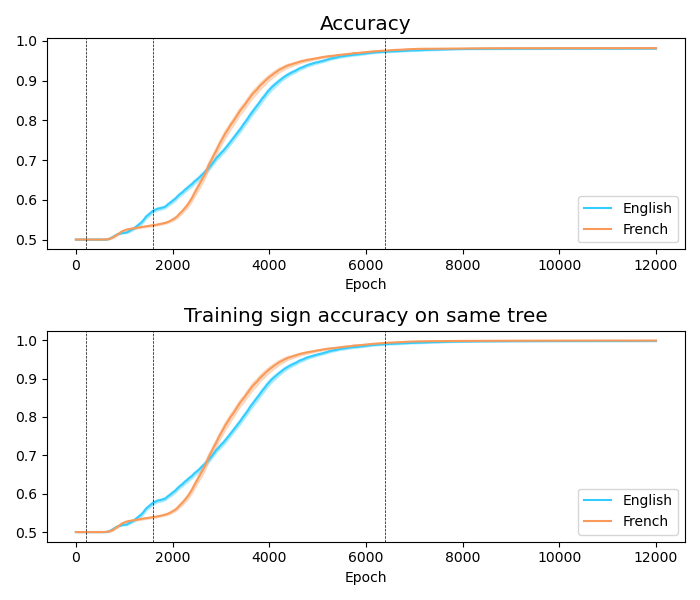

In [8]:
# Plot reports
# report_types = ['loss', 'weighted_acc', 'frac_perfect', 'test_frac_perfect', 'test_weighted_acc']
report_types = ['weighted_acc_loose', 'weighted_acc_loose_indomain']
report_types = list(filter(lambda t: t in next(iter(curr_sets.values()))['reports'], report_types))

fig, axs = util.make_plot_grid(len(report_types), 1, ax_dims=(7, 3),
                               #prop_cycle=cycler(color=['k']).concat(col_cycle))
                               prop_cycle=prop_cycle_pairs)

epochs_of_interest = np.array([0, 200, 1600, 6400])

for ax, rtype in zip(axs, report_types):
    if rtype == 'loss':
        ax.set_yscale('log')
    
    for run_name, res in curr_sets.items():
        name = re.search(r'(\w+)$', run_name).group(1)
        col = color_map[name]
        net_analysis.plot_report(ax, res, rtype, label=name, color=col, title=report_titles[rtype])
        
        # plot epochs of interest
        # report_freq = res['train_params']['report_freq']
        # inds_of_interest = epochs_of_interest // report_freq
        # ind_vals = res['reports'][rtype][inds_of_interest]
        # ax.plot(epochs_of_interest, ind_vals, 'r', ls='none', marker=MarkerStyle('o', 'none'), mew=1)
        
    ax.set_ylim(ax.get_ylim())
    for epoch in epochs_of_interest[1:]:
        ax.plot([epoch, epoch], ax.get_ylim(), 'k--', lw=0.5)
        
    ax.legend()
    ax.set_title(ax.get_title(), size='x-large')
    
fig.tight_layout()
plt.show()

# with mpl.rc_context({'svg.fonttype': 'none'}):
#     util.print_svg(fig, 'figures/family_tree/shared_training_w_markers.svg')

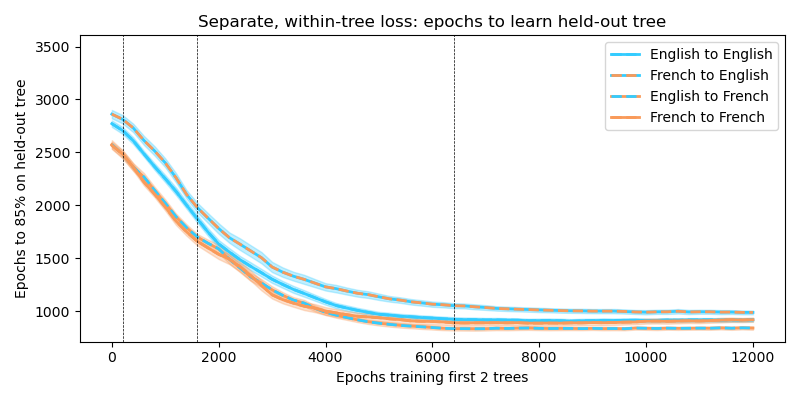

In [9]:
# Plot epochs-to-generalize, 1 plot per type of network
# colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# A little hacky: assume any value of the runs dict with a length of 4 is a 2x2 train/test set of runs.
tree_holdout_runs = {key: runs for key, runs in curr_sets_nested.items() if len(runs) == 4}

n_types = len(tree_holdout_runs)
fig, axs = util.auto_subplots(n_types, 1, ax_dims=(8, 4))

for (label, runs), ax in zip(tree_holdout_runs.items(), axs.ravel()):
    h_lines = [[], []]  # first held-out, then trained-on
    ax.set_title(f'{label}: epochs to learn held-out tree')
#     color_iter = iter(colors)
#     color_dict = {}
    legend_entries = []
    
    for key, run in runs.items():
        from_name, to_name = re.search(r'([-0-9a-zA-Z]+) (?:[-=]+>|to) ([-0-9a-zA-Z]+)', key).groups()
#         if from_name not in color_dict:
#             color_dict[from_name] = next(color_iter)
#         if to_name not in color_dict:
#             color_dict[to_name] = next(color_iter)
        
        etg_epochs = run['etg_epochs']
        mean_etg = run['reports']['new_tree_etg']
        ci_etg = run['report_cis']['new_tree_etg']
        # mean_etg = run['report_meds']['new_tree_etg']
        # ci_etg = run['report_med_cis']['new_tree_etg']
        thresh_pct = run['train_params']['test_thresh'] * 100
        trained_trees = run['net_params']['n_train_domains']

        h_lines[0].append(ax.plot(etg_epochs, mean_etg, color=color_map[to_name], ls='-', lw=2)[0])  # tested-on
        h_lines[1].append(ax.plot(etg_epochs, mean_etg, color=color_map[from_name], ls='--', lw=2)[0])  # trained-on

        ax.fill_between(etg_epochs, *ci_etg, alpha=0.3, color=color_map[to_name])
        
        legend_entries.append(f'{from_name} to {to_name}')
        
    curr_ylims = ax.get_ylim()
    new_ylims = (curr_ylims[0], curr_ylims[1] * 1.2)
    ax.set_ylim(new_ylims)    
    
    # add lines for epochs of interest
    for epoch in epochs_of_interest[1:]:
        ax.plot([epoch, epoch], new_ylims, 'k--', lw=0.5)

    ax.legend(list(zip(*h_lines)), legend_entries)
    ax.set_xlabel(f'Epochs training first {trained_trees} trees')
    ax.set_ylabel(f'Epochs to {thresh_pct:g}% on held-out tree')

fig.tight_layout()
plt.show()

with mpl.rc_context({'svg.fonttype': 'none'}):
    util.print_svg(fig, 'figures/family_tree/dho_timecourse_separate_intree_loss.svg')

In [17]:
# Violin plots of ETG at epochs of interest

run_set_name = 'Asymmetric tree holdout (train 2, shared rels)'

tree_holdout_runs = {key: runs for key, runs in curr_sets_nested.items() if len(runs) == 4}
runs = tree_holdout_runs[run_set_name]

epochs_to_use = epochs_of_interest[1:]

with sns.axes_style('whitegrid'):
    sns.set_palette('tab10')
    # fig, axs = util.make_plot_grid(len(epochs_to_use), 2, ax_dims=(6, 4))

    def interpret_label(label):
        match = re.search(r'(\w+) -> (\w+)', label)
        return match[1].capitalize(), match[2].capitalize()

    tree_dtype = pd.CategoricalDtype(categories=['English', 'French'], ordered=True)
    same_dtype = pd.CategoricalDtype(categories=['Same', 'Different'], ordered=True)
    epoch_dtype = pd.CategoricalDtype(categories=[str(ep) for ep in epochs_to_use], ordered=True)

    from_str = 'Trained on'
    to_str = 'Tested on'
    same_str = 'Train vs. test tree'
    epoch_str = 'Training epochs'
    etg_str = 'Epochs to 85% on held-out tree'
    cols = [from_str, to_str, same_str, epoch_str, etg_str]
    vplot_data = pd.DataFrame(columns=cols)
    
    for label, run in runs.items():
        from_tree, to_tree = interpret_label(label)
        inds = np.flatnonzero(np.isin(run['etg_epochs'], epochs_to_use))
        
        with np.load(run['path'], allow_pickle=True) as resfile:
                etg_vals_all = resfile['reports'].item()['new_tree_etg'][:, inds]
                
        for i, epoch in enumerate(epochs_to_use):            
            new_df = pd.DataFrame({from_str: from_tree, to_str: to_tree, same_str: 'Same',
                                   epoch_str: str(epoch), etg_str: etg_vals_all[:, i]})
            new_df.loc[new_df[from_str] != new_df[to_str], same_str] = 'Different'
            vplot_data = pd.concat([vplot_data, new_df])

    vplot_data[from_str] = vplot_data[from_str].astype(tree_dtype)
    vplot_data[to_str] = vplot_data[to_str].astype(tree_dtype)
    vplot_data[same_str] = vplot_data[same_str].astype(same_dtype)
    vplot_data[epoch_str] = vplot_data[epoch_str].astype(epoch_dtype)
    vplot_data[etg_str] = vplot_data[etg_str].astype(np.int32)
        
#     g = sns.catplot(kind='bar', x=to_str, y=etg_str, hue=same_str, col=epoch_str, col_wrap=2, ci=68,
#                     sharey=False, data=vplot_data, n_boot=10000) #, inner='box')
    
#     g.figure.suptitle(run_set_name)    
#     g.tight_layout()
#     plt.show()
    # util.print_svg(fig, 'figures/famtree_separate_violin.svg')

Epoch 200: p = 5.6494787355214465e-12
Epoch 1600: p = 5.132228289146953e-07
Epoch 6400: p = 0.020130637884699265


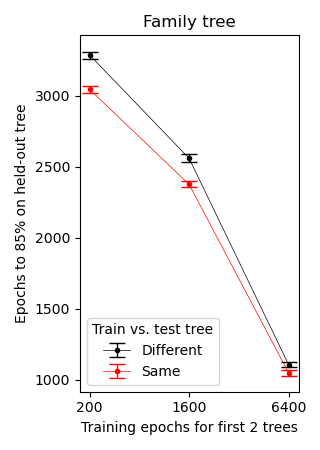

In [18]:
# Violin plots of ETG, collapsed across English/French

# with sns.axes_style('whitegrid'):
#     sns.set_palette('tab10')
#     fig, ax = plt.subplots(figsize=(10, 4))
#     g = sns.catplot(kind='bar', x=epoch_str, y=etg_str, hue=same_str, data=vplot_data, n_boot=100000)#, inner='box')
    # sns.set_palette(['white', '#AAAAAA'])
    # g = sns.catplot(kind='violin', x=epoch_str, y=etg_str, hue=same_str, data=vplot_data, inner='box', legend_out=False, aspect=1.7)
    # g.set_xlabels('Training epochs on first 2 trees', size='large')
    # g.set_ylabels(g.ax.get_ylabel(), size='large')
    # sep_shared = re.search(r'(separate|shared) rels', run_set_name).group(1)
    # g.figure.suptitle(f'Generalization test results (family tree, {sep_shared} relationships)', size='x-large')
    # g.tight_layout()
    
# stick plots with standard error errorbars
fig, ax = plt.subplots(figsize=(3.2, 4.5))
diff_means = np.empty(len(epochs_to_use))
diff_ses = np.empty_like(diff_means)
same_means = np.empty_like(diff_means)
same_ses = np.empty_like(diff_means)

for i, epoch in enumerate(epochs_to_use):
    different_data = vplot_data[(vplot_data[same_str] == 'Different') & (vplot_data[epoch_str] == str(epoch))]
    diff_means[i] = np.mean(different_data[etg_str])
    diff_ses[i] = np.std(different_data[etg_str]) / np.sqrt(len(different_data))

    same_data = vplot_data[(vplot_data[same_str] == 'Same') & (vplot_data[epoch_str] == str(epoch))]
    same_means[i] = np.mean(same_data[etg_str])
    same_ses[i] = np.std(same_data[etg_str]) / np.sqrt(len(same_data))
    
    _, p = stats.ttest_ind(same_data[etg_str], different_data[etg_str])
    print(f'Epoch {epoch}: p = {p}')

ax.errorbar(range(len(epochs_to_use)), diff_means, yerr=diff_ses, fmt='k.-', capsize=6, lw=0.5, elinewidth=1, capthick=1, label='Different')
ax.errorbar(range(len(epochs_to_use)), same_means, yerr=same_ses, fmt='r.-', capsize=6, lw=0.5, elinewidth=1, capthick=1, label='Same')
ax.set_xticks(range(len(epochs_to_use)))
ax.set_xticklabels([str(epoch) for epoch in epochs_to_use])
ax.set_xlabel('Training epochs for first 2 trees')
ax.set_ylabel('Epochs to 85% on held-out tree')
ax.legend(loc='lower left', title='Train vs. test tree')
ax.set_title('Family tree')

fig.tight_layout()
plt.show()

# with mpl.rc_context({'svg.fonttype': 'none'}):
#     util.print_svg(fig, 'figures/family_tree/gen_test_stick_shared.svg')

In [107]:
# Plot how people map onto each representation layer unit (see Figure 6 in Hinton paper)
res_name = '2 trees'
run_num = 1
epoch = -1
snapshot = res_data[res_name]['snaps']['person1_repr'][run_num, epoch]
n_people, n_repr_units = snapshot.shape

fig, axs = util.make_plot_grid(n_repr_units, n_cols=2, ax_dims=(6, 2))

for unit_ind, (unit_snap, ax) in enumerate(zip(snapshot.T, axs)):
    im = util.imshow_pos(ax, unit_snap.reshape(2, -1))
    util.add_colorbar(im)
    ax.set_title(f'Unit {unit_ind + 1}')
    
    if n_repr_units - unit_ind <= 2:
        ax.set_xticks(range(n_people // 2))
        ax.set_xticklabels([p.name for p in english_tree.members], rotation=45, ha='right')
    else:
        ax.set_xticks([])
    
    if unit_ind % 2 == 0:
        ax.set_yticks(range(2))
        ax.set_yticklabels(['English', 'Italian'])
    else:
        ax.set_yticks([])
    
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Name key
--------
 0: Christopher
 1: Penelope
 2: Andrew
 3: Christine
 4: Margaret
 5: Arthur
 6: Victoria
 7: James
 8: Jennifer
 9: Charles
10: Colin
11: Charlotte



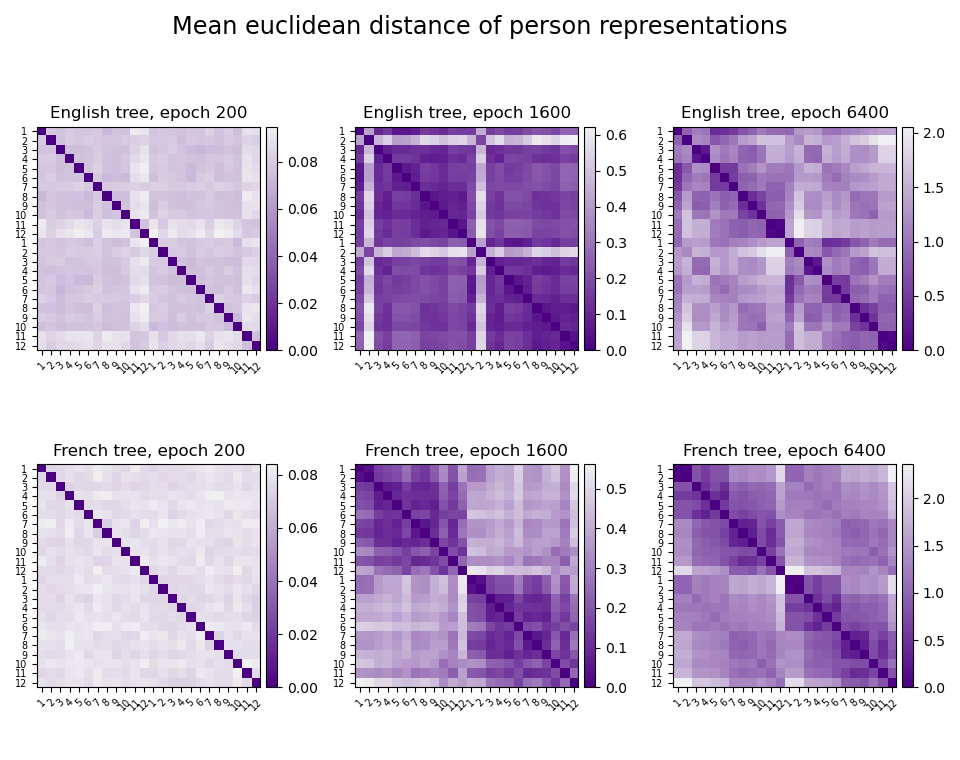

In [19]:
# Plot RDMs (at person representation layer)

run_num = None
# run_num = 0
plot_type = 'dist'

total_snaps = min([sum(res['train_params']['num_epochs']) // res['train_params']['snap_freq'] for res in curr_sets.values()])
# inds_to_plot = np.arange(0, 161, 5)
# inds_to_plot = epochs_of_interest // 50
epochs_to_plot = epochs_of_interest[1:]
layer = 'person1_repr'

layer_names = {
    'person1_repr': 'person 1 repr.',
    'person1_hidden': 'person 1 hidden repr.',
    'relation_repr': 'relationship repr.',
    'relation_hidden': 'relationship hidden repr.'
}

# print key
print('Name key')
print('--------')
for memb_ind, memb in enumerate(english_tree.members):
    print(f'{memb_ind:2}: {memb.name}')
print()

# fig, axss = util.auto_subplots(len(inds_to_plot), n_curr, ax_dims=(3, 3))
fig, axss = util.auto_subplots(n_curr, len(epochs_to_plot), ax_dims=(3.2, 3.8))  # horizontal orientation
axss = axss.T

# for ind, axs in zip(inds_to_plot, axss):
for epoch, axs in zip(epochs_to_plot, axss):
    for (label, res), ax in zip(curr_sets.items(), axs):
        ind = epoch // res['train_params']['snap_freq']
        res = curr_sets[label]
        if 'single_tree' in res['net_params']:
            family_strings = ['E'] if res['net_params']['single_tree'] else ['E', 'I']
        else:
            family_strings = [tree_name[0].upper() for tree_name in res['net_params']['trees'][:res['net_params']['n_train_domains']]]
        # person_labels = [f'{fam}{memb_ind}' for fam, memb_ind in itertools.product(family_strings, range(len(english_tree.members)))]
        person_labels = [str(i+1) for i in range(len(english_tree.members))] * res['net_params']['n_train_domains']
        
        if ind < len(res['snap_epochs']):
            # label_split = '\n'.join(label.split('/')) + ', '
#             title_addon = ', '.join(filter(lambda s: len(s) > 0, re.match(r'^(Asymmetric|).*(separate|shared).*(English|French)', label).groups()))
            tree_name = re.search(r'(\w+)$', label).group(1)
            plot_fn = net_analysis.plot_repr_corr if plot_type == 'corr' else net_analysis.plot_rdm
            actual_mat = res['repr_corr'][layer]['snaps_each'][run_num, ind] if run_num is not None else None
            plot_fn(ax, res, layer, ind, person_labels, actual_mat=actual_mat, colorbar=True)
            ax.set_title(f'{tree_name} tree, epoch {epoch}')

if plot_type == 'corr':
    fig.suptitle('Mean correlation of person representations' + (f', run {run_num}' if run_num is not None else ''), size='xx-large')
else:
    fig.suptitle(f'Mean {load_settings["dist_metric"]} distance of person representations', size='xx-large')
    
fig.tight_layout(rect=(0, 0, 1, 0.98))
plt.show()
util.print_svg(fig, 'figures/family_tree/shared_dists.svg')

In [51]:
# Lampinen SVD analysis
def get_n_analogous_modes(res, n_shuffle=1000, plot_modes=False):
    use_flipped = not res['net_params']['share_rel_units']
    first_layer_weights = np.squeeze(res['snaps']['person1_repr_preact'][:, -1])  # n_runs x n_people x n_units
    n_runs, n_people, n_units = first_layer_weights.shape

    # permutation of people that flips the tree left/right without changing the structure (only for English/Italian tree).
    # Effectively exchanges everyone with their opposite-gender counterpart.
    flip_perm = [3, 2, 1, 0, 9, 8, 7, 6, 5, 4, 11, 10]

    num_sig_modes = np.zeros(n_runs)
    num_sig_modes_flipped = np.zeros(n_runs) if use_flipped else None
    num_sig_modes_null = np.zeros(n_runs)

    def cross_tree_mode_corr(input_mode_mat):
        """Input is n_people x n_modes"""
        tree1_modes, tree2_modes = np.split(input_mode_mat, 2)
        return np.sum(tree1_modes * tree2_modes, axis=0)

    def get_n_sig_modes(this_mode_corr, shuffled_mode_corrs, alpha=0.05):
        """
        this_mode_corr: vector of correlations of input modes between two families
        shuffled_mode_corrs: n_shuffle x n_modes matrix of shuffled mode corrs
        """
        shuffled_greater_than_this = shuffled_mode_corrs > this_mode_corr
        this_mode_sig = np.sum(shuffled_greater_than_this, axis=0) < alpha * n_shuffle
        return np.sum(this_mode_sig)

    if plot_modes:
        fig, axs = util.make_plot_grid(6, 3, ravel=True)

    for k_run, weights in enumerate(first_layer_weights):
        input_modes = svd(weights, full_matrices=False)[0]

        shuffled_mode_corrs = np.stack([cross_tree_mode_corr(input_modes[util.choose_k_inds(n_people, n_people)]) for _ in range(n_shuffle)])

        real_mode_corr = cross_tree_mode_corr(input_modes)
        num_sig_modes[k_run] = get_n_sig_modes(real_mode_corr, shuffled_mode_corrs)

        input_modes_null = input_modes[util.choose_k_inds(n_people, n_people)]
        null_mode_corr = cross_tree_mode_corr(input_modes_null)
        num_sig_modes_null[k_run] = get_n_sig_modes(null_mode_corr, shuffled_mode_corrs)

        if use_flipped:
            input_modes_flipped = input_modes.copy()
            input_modes_flipped[:len(flip_perm)] = input_modes_flipped[flip_perm]
            flipped_mode_corr = cross_tree_mode_corr(input_modes_flipped)
            num_sig_modes_flipped[k_run] = get_n_sig_modes(flipped_mode_corr, shuffled_mode_corrs)

        if plot_modes and k_run < 6:
            util.imshow_centered_bipolar(axs[k_run], input_modes)
            axs[k_run].set_xlabel('Modes')
            axs[k_run].set_ylabel('People')
            axs[k_run].set_title(f'SVD input modes, run {k_run + 1}')

    if plot_modes:
        fig.tight_layout()
        plt.show()
    
    return num_sig_modes, num_sig_modes_flipped, num_sig_modes_null

n_sig_modes_separate, n_sig_modes_flipped_separate, n_sig_modes_null_separate = get_n_analogous_modes(curr_sets['Separate with P1 preact'], plot_modes=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [46]:
# Make violin plot of significantly analogous modes
num_modes_data = {
    'Regular': n_sig_modes_separate,
    'Flipped': n_sig_modes_flipped_separate,
    'Null Dist.': n_sig_modes_null_separate
}

df = pd.DataFrame(num_modes_data)

fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(data=df, inner='stick', ax=ax)
ax.set_xlabel('Analogy')
ax.set_ylabel('# significant modes')
ax.set_title('Analogous modes between families (separate relationships, 2 hidden layers)')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [52]:
# Make violin plot of significantly analogous modes
n_sig_modes_shared, _, n_sig_modes_null_shared = get_n_analogous_modes(curr_sets['Shared with P1 preact'])

num_modes_data = {
    'Regular': n_sig_modes_shared,
    'Null Dist.': n_sig_modes_null_shared
}

df = pd.DataFrame(num_modes_data)

fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(data=df, inner='stick', ax=ax)
ax.set_xlabel('Analogy')
ax.set_ylabel('# significant modes')
ax.set_title('Analogous modes between families (shared relationships, 2 hidden layers)')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [58]:
# Shared/separate combined plot

num_modes_data_full = {
    'Shared rels': n_sig_modes_shared,
    'Separate rels': n_sig_modes_separate + n_sig_modes_flipped_separate,
    'Null Dist.': np.concatenate([n_sig_modes_null_separate, n_sig_modes_null_shared])
}

dfs = [pd.DataFrame(data={'Analogy': label, 'NumModes': data}) for label, data in num_modes_data_full.items()]
df = pd.concat(dfs)

fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(data=df, x='Analogy', y='NumModes', inner='stick', ax=ax)
# ax.set_xlabel('Analogy')
ax.set_ylabel('# significant modes')
ax.set_title('Analogous modes between families (2 hidden layers)')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

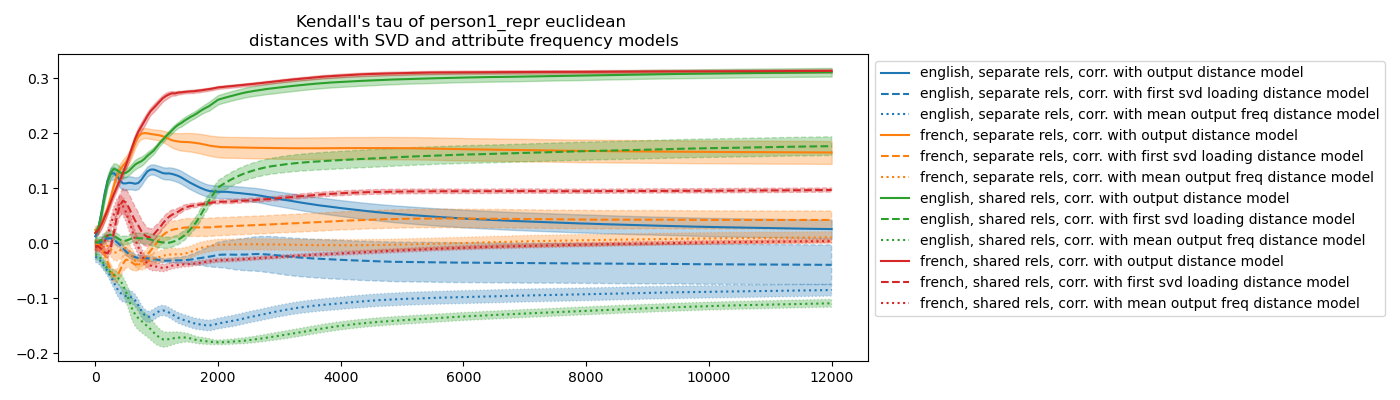

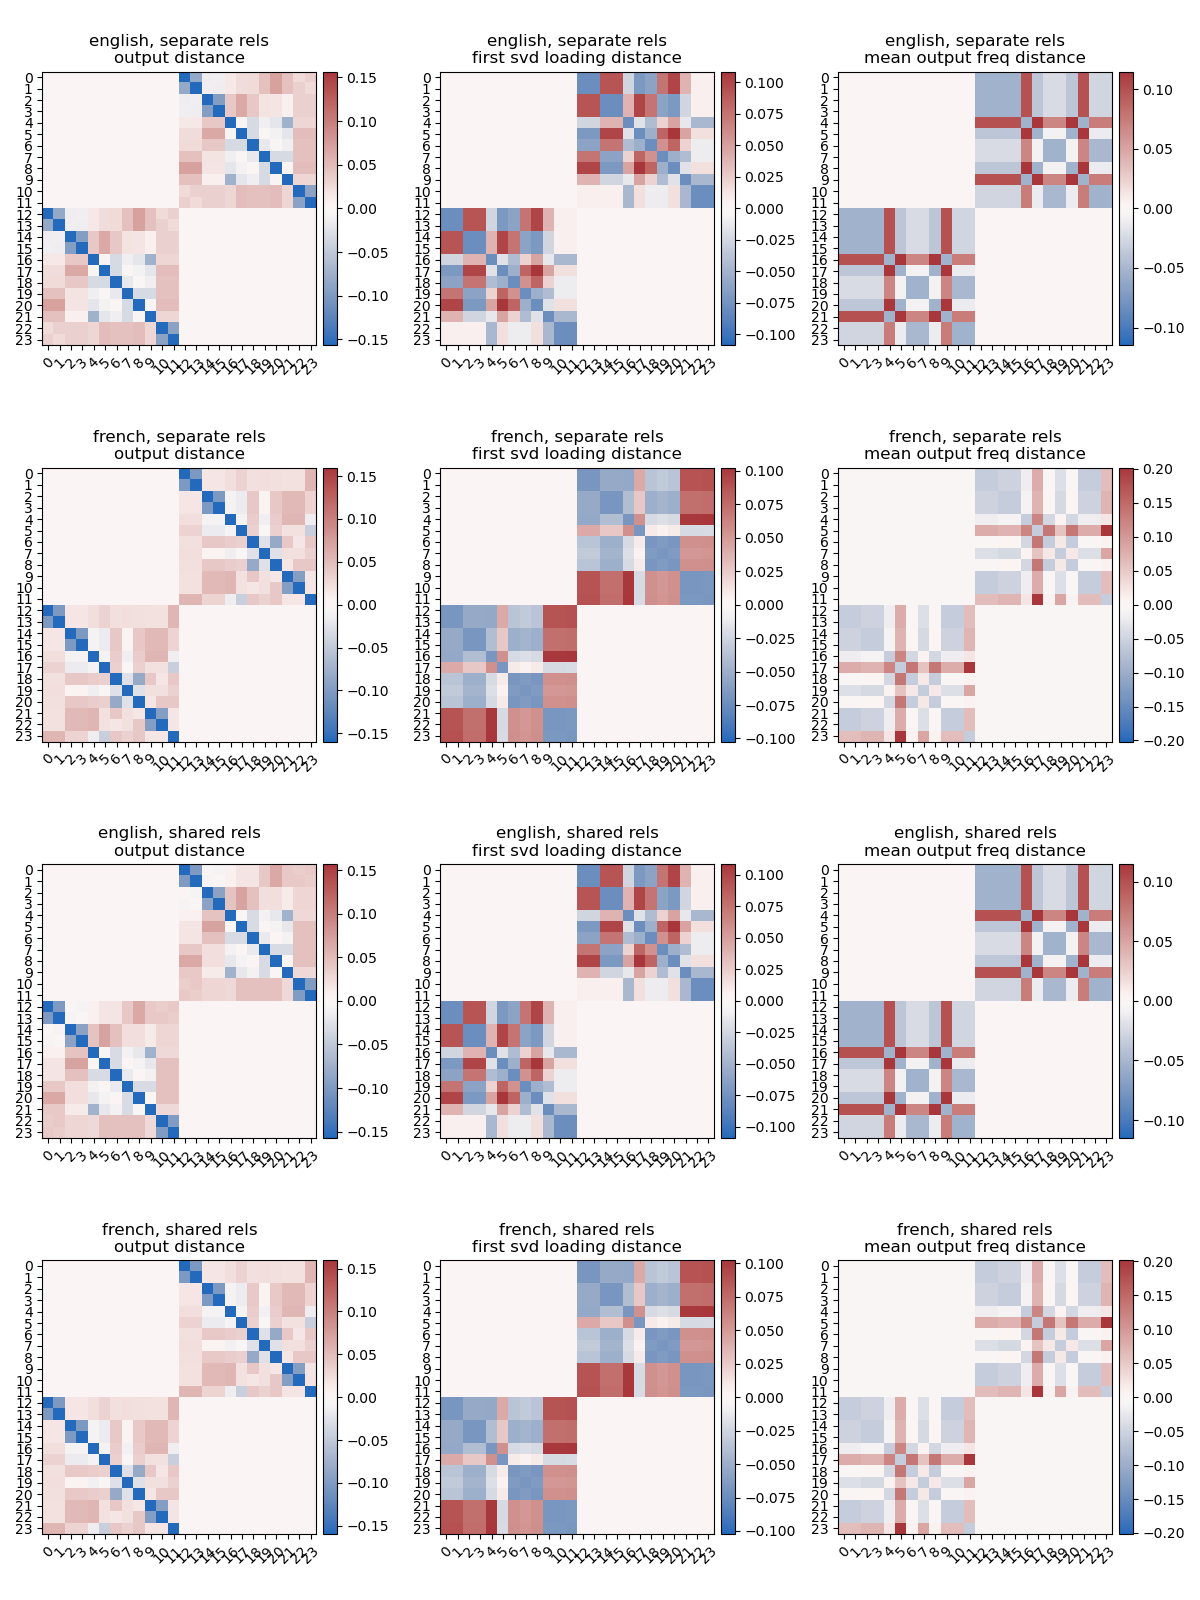

In [5]:
# Try correlating each 2x2 item repr corr matrix with individual SVD and/or attr freq distance, as applicable
colors = [d['color'] for d in list(col_cycle)]
linestyles = ['-', '--', ':']

model_names = {
    'svd': 'output distance',
    'svd_first': 'first svd loading distance',
    'attr_freq': 'mean output freq distance'
}

corr_names = {
    'pearson': 'Correlation',
    'spearman': 'Spearman\'s r',
    'kendall': 'Kendall\'s tau'
}

corr_type = 'kendall'
snap_type = 'person1_repr'

PEOPLE_PER_TREE = 12

def get_model_corrs(res):
    n_train_domains = res['net_params']['n_train_domains']
    train_items = np.arange(PEOPLE_PER_TREE * n_train_domains)

    tree_id = res['net_params']['trees'][0]
    tree = familytree.get_tree(tree_id)
    p1_mat, _, p2_mat = tree.get_io_mats()
    
    def get_svd_dist_model(modes_to_use):
        """
        Get model that expects off-diagonal blocks to resemble the average SVD distance matrix over all domains
        Now returns a 3D array with a separate model for each run.
        """
        svd_dist = util.center_and_norm_rdm(pa.get_contextfree_item_svd_dist(p1_mat, p2_mat, 1, modes_to_use))
        # tile over full set of trained items (block diagonal will be zeroed later)
        return np.tile(svd_dist, (n_train_domains, n_train_domains))
    
    full_p1_mat = block_diag(*([p1_mat] * n_train_domains))
    full_p2_mat = block_diag(*([p2_mat] * n_train_domains))
    attr_freq_dist_mat = pa.get_attr_freq_dist_mat(full_p1_mat, full_p2_mat)
    
    models = {
        'svd': get_svd_dist_model(slice(None)),
        'svd_first': get_svd_dist_model([0]),
        'attr_freq': util.center_and_norm_rdm(attr_freq_dist_mat)
    }
        
    # set all block diagonal entries to zero - we want to focus on the off-diagonal entries
    offdiag_mask = train_items[np.newaxis, :] // PEOPLE_PER_TREE != train_items[:, np.newaxis] // PEOPLE_PER_TREE
    for model_name in models:
        models[model_name] = np.where(offdiag_mask, models[model_name], 0)
        models[model_name] = util.center_and_norm_rdm(models[model_name])

    return models, net_analysis.get_rdm_projections(res, snap_type, models, corr_type=corr_type)

def plot_corr_ci(ax, res, corr, label, color, style):
    mean, (lower, upper) = util.get_mean_and_ci(corr)
    ax.plot(res['snap_epochs'], mean, label=label, color=color, linestyle=style)
    ax.fill_between(res['snap_epochs'], lower, upper, alpha=0.3, color=color, linestyle=style)

# For matrix plots of models
fig1, model_axss = util.auto_subplots(len(curr_sets), len(model_names))

fig2, ax2 = plt.subplots(figsize=(14, 4))
ax2.set_title(f'{corr_names[corr_type]} of {snap_type} {load_settings["dist_metric"]} \n' +
              'distances with SVD and attribute frequency models')

for (res_name, res), col, model_axs in zip(curr_sets.items(), colors, model_axss):
    label = re.search(r', ([^,]+)\)\\(\w+) ', res_name).expand(r'\2, \1')
    models, res_corrs = get_model_corrs(res) 
    for (model_type, model), ls, model_ax in zip(models.items(), linestyles, model_axs):
        util.plot_matrix_with_labels(model_ax, model, [str(k) for k in range(len(model))])
        model_ax.set_title(f'{label}\n{model_names[model_type]}')
        
        plot_corr_ci(ax2, res, res_corrs[model_type], label + f', corr. with {model_names[model_type]} model', col, ls)

util.outside_legend(ax2)
fig1.tight_layout()
fig2.tight_layout()
plt.show()

D:\Ethan\anna_stuff\disjoint-domain\problem_analysis.py:36: RuntimeWarning: Mean of empty slice
  mean_dist = np.nanmean(np.stack([distfn(a) for a in attr_mats]), axis=0)


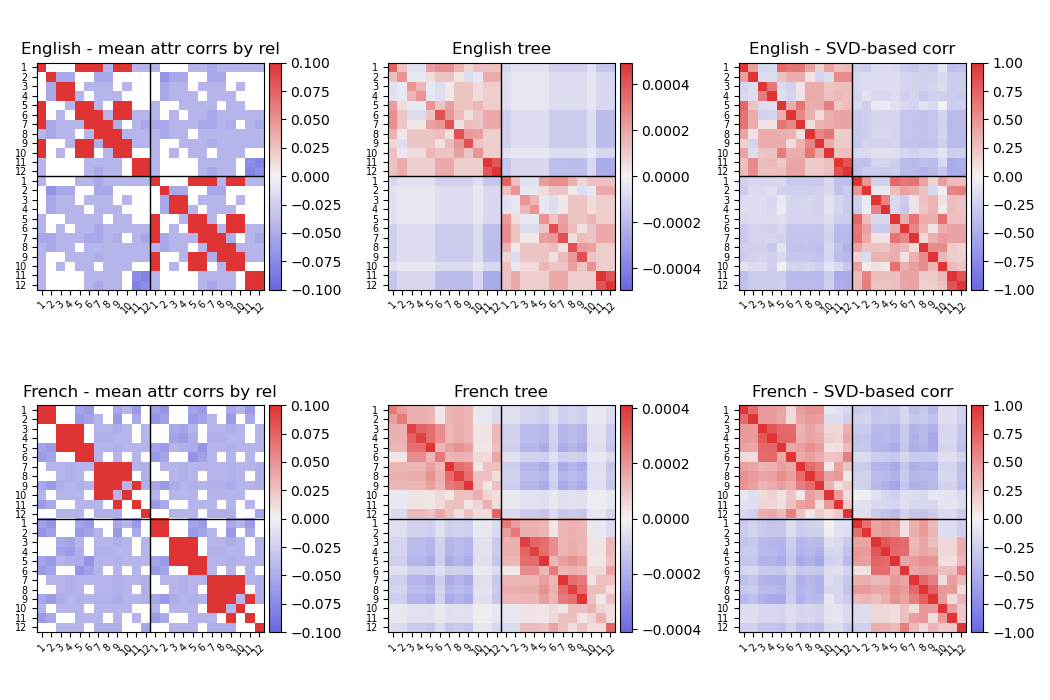

In [4]:
# just ground truth attribute correlation
# compare 3 methods

fig, axss = util.auto_subplots(n_curr, 3, ax_dims=(3.5, 3.5)) 

for (res_name, res), axs in zip(curr_sets.items(), axss):
    n_domains = res['net_params']['n_train_domains']
    label = re.search(r'(\w+)$', res_name).expand(r'\1')
    all_p2_mats_by_rel = []
    all_p1_mats = []
    all_p2_mats = []
    
    for tree_id in res['net_params']['trees'][:n_domains]:    
        tree = familytree.get_tree(tree_id)
        all_p2_mats_by_rel.append(tree.get_person2_mats_by_rel(nan_if_none=True))
        p1_mat, _, p2_mat = tree.get_io_mats()
        all_p1_mats.append(p1_mat)
        all_p2_mats.append(p2_mat)
        
    n_p1 = [mat.shape[1] for mat in all_p1_mats]
    
    # polyfill for pairwise
    def pairwise(iterable):
        # pairwise('ABCDEFG') --> AB BC CD DE EF FG
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)
    
    assert all(x == y for x, y in pairwise(n_p1)), 'Not all trees have the same number of people'
    total_n_p1 = sum(n_p1)
    p1_per_domain = n_p1[0]
    ax_labels = [str(k+1) for k in range(p1_per_domain)] * n_domains
        
    # Method 1: averaging corrs for individual relationships
    full_p2_mats_by_rel = [block_diag(*rel_p2_mat_of_each_tree) for rel_p2_mat_of_each_tree in zip(*all_p2_mats_by_rel)]
    averaged_corr = pa.get_attribute_rdm(full_p2_mats_by_rel, metric='corr')
    util.plot_matrix_with_labels(axs[0], averaged_corr, ax_labels, tick_fontsize='x-small')
    axs[0].set_title(f'{label} - mean attr corrs by rel')
    
    # Method 2: item corrs based on context-free io corr matrices     
    full_p1_mat = block_diag(*all_p1_mats)
    full_p2_mat = block_diag(*all_p2_mats)
    
    ctxfree_io_mat = pa.get_contextfree_io_corr_matrix(full_p1_mat, full_p2_mat)
    centered_io_mat = ctxfree_io_mat - np.mean(ctxfree_io_mat, axis=0)
    io_mat_item_corrs = centered_io_mat.T @ centered_io_mat
    util.plot_matrix_with_labels(axs[1], io_mat_item_corrs, ax_labels, tick_fontsize='x-small')
    axs[1].set_title(f'{label} tree')
    
    # Method 3: correlation of SVD loadings
    svd_loading_corr = pa.get_contextfree_item_svd_corr(full_p1_mat, full_p2_mat, 1, slice(None))
    util.plot_matrix_with_labels(axs[2], svd_loading_corr, ax_labels, tick_fontsize='x-small')
    axs[2].set_title(f'{label} - SVD-based corr')
    
    for ax in axs:
        # domain dividers
        for divider_pt in np.arange(p1_per_domain-0.5, total_n_p1-0.5, p1_per_domain):
            ax.plot(ax.get_xlim(), [divider_pt, divider_pt], 'k', lw=1)
            ax.plot([divider_pt, divider_pt], ax.get_ylim(), 'k', lw=1)
    
fig.tight_layout()
plt.show()

with mpl.rc_context({'svg.fonttype': 'none'}):
    util.print_svg(fig, 'figures/family_tree/corr_models.svg')

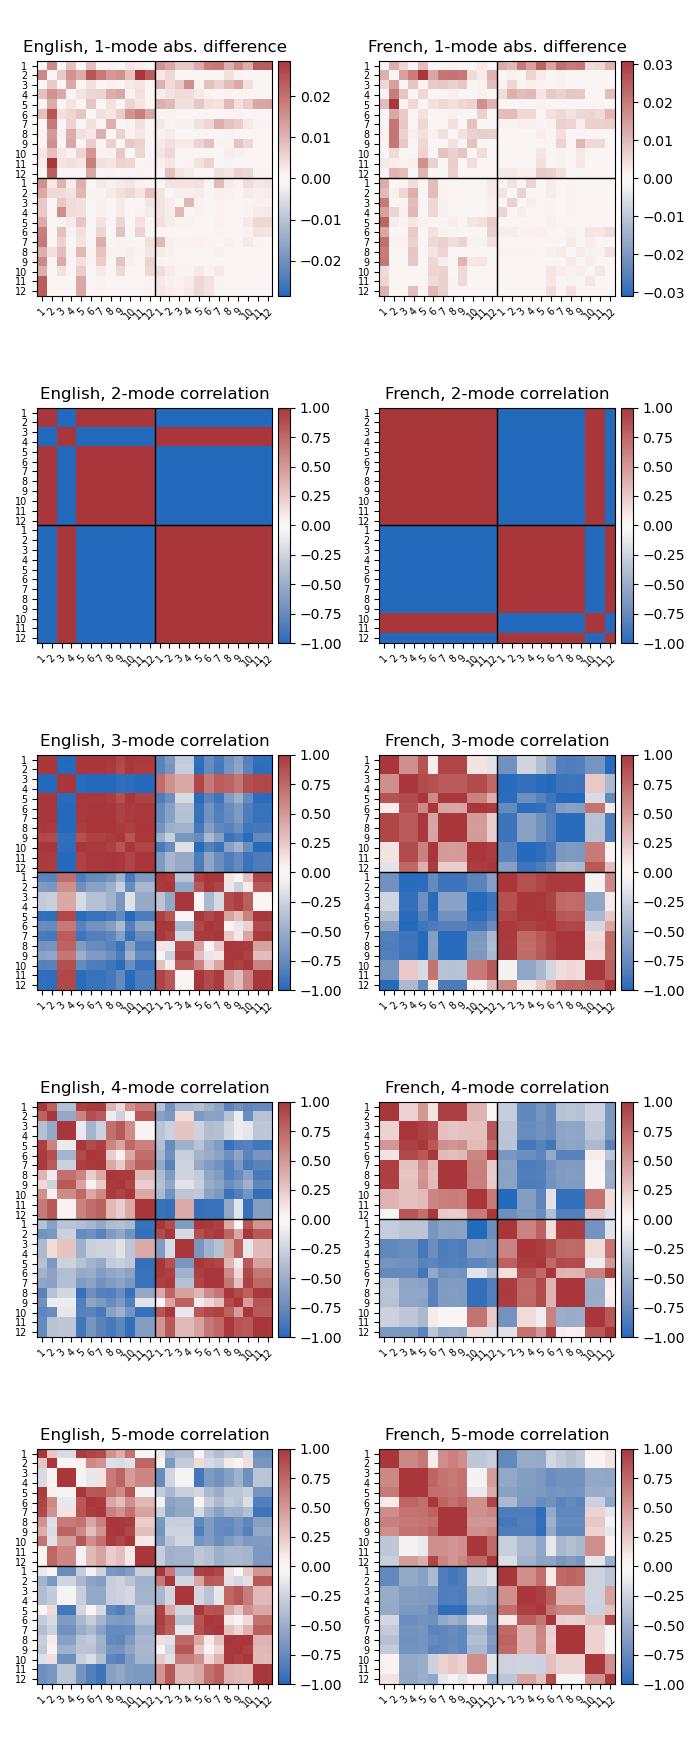

In [64]:
# Plot ground truth iomat correlations for subsets of SVD components

n_compss = range(1, 6)

fig, axss = util.auto_subplots(len(n_compss), n_curr, ax_dims=(3.5, 3.5))
axss = axss.T

for (res_name, res), axs in zip(curr_sets.items(), axss):
    n_domains = res['net_params']['n_train_domains']
    label = re.search(r'(\w+)$', res_name).expand(r'\1')
    all_p1_mats = []
    all_p2_mats = []
    
    for tree_id in res['net_params']['trees'][:n_domains]:    
        tree = familytree.get_tree(tree_id)
        p1_mat, _, p2_mat = tree.get_io_mats()
        all_p1_mats.append(p1_mat)
        all_p2_mats.append(p2_mat)
        
    n_p1 = [mat.shape[1] for mat in all_p1_mats]
        
    full_p1_mat = block_diag(*all_p1_mats)
    full_p2_mat = block_diag(*all_p2_mats)
    
    # polyfill for pairwise
    def pairwise(iterable):
        # pairwise('ABCDEFG') --> AB BC CD DE EF FG
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)
    
    assert all(x == y for x, y in pairwise(n_p1)), 'Not all trees have the same number of people'
    total_n_p1 = sum(n_p1)
    p1_per_domain = n_p1[0]
    ax_labels = [str(k+1) for k in range(p1_per_domain)] * n_domains
        
    for ax, n_comps in zip(axs, n_compss):
        if n_comps == 1:
            # can't use correlation with just 1 component
            svd_loading_mat = pa.get_item_svd_loadings(full_p1_mat, full_p2_mat, 1, center=False)
            svd_loading_subcorr = np.abs(svd_loading_mat - svd_loading_mat.T)
            description = 'abs. difference'
        else:
            svd_loading_subcorr = pa.get_contextfree_item_svd_corr(full_p1_mat, full_p2_mat, 1, range(n_comps))
            description = 'correlation'
            
        util.plot_matrix_with_labels(ax, svd_loading_subcorr, ax_labels, tick_fontsize='x-small')
        ax.set_title(f'{label}, {n_comps}-mode {description}')
        
        for divider_pt in np.arange(p1_per_domain-0.5, total_n_p1-0.5, p1_per_domain):
            ax.plot(ax.get_xlim(), [divider_pt, divider_pt], 'k', lw=1)
            ax.plot([divider_pt, divider_pt], ax.get_ylim(), 'k', lw=1)
            
fig.tight_layout()
plt.show()

util.print_svg(fig, 'figures/family_tree/svd_mode_corrs.svg')